In [1]:
# Imports 
import librosa
import librosa.display
import librosa.effects
import librosa.util

import numpy as np
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformer_models import *
from transformer_data import *

In [2]:
# Helper function from homework
def pad_wav(wav, wav_max_length, pad=0):
    """Pads audio wave sequence to be `wav_max_length` long."""
    dim = wav.shape[1]
    padded = np.zeros((wav_max_length, dim)) + pad
    if len(wav) > wav_max_length:
        wav = wav[:wav_max_length]
    length = len(wav)
    padded[:length, :] = wav
    return padded, length

In [3]:
#Features we want right now: min f0, max f0, and mean f0 and maybe rms (not sure exactly what that is but was used in the paper)
path = '/home/CREMA-D/AudioWAV/'
files = os.listdir(path)

summary = pd.read_csv('/home/CREMA-D/processedResults/summaryTable.csv')

num_files = len(os.listdir(path)) #not sure how you want to count files
count = 0

# Aim to get to 12 features
num_features = 6

mels = False

# Keep track of min and max duration of all data
min_dur = np.inf
max_dur = 0
max_length = 0

# mel spectrogram is padded to 250, and n_mels is default 128
if mels:
    X = np.zeros((num_files, num_features + 250 * 128))
else:
    X = np.zeros((num_files, num_features))
Y = np.zeros(num_files).astype(str)
for sample in tqdm(files): #depends on how you access
    file = os.path.join(path,sample)
    current_wav, current_sr = librosa.load(file) #fix for set up 
    
    # Mel spectrogram
    if mels:
        mel_spec = librosa.feature.melspectrogram(y=current_wav, sr=current_sr)
        m_log = librosa.power_to_db(mel_spec)
        m_log_norm = librosa.util.normalize(m_log)
        padded_wav, input_length = pad_wav(m_log_norm.T, 250)
        flat_mel = padded_wav.flatten()
    
    # Prosodic features
    f0_series = librosa.yin(current_wav, librosa.note_to_hz('C2'), librosa.note_to_hz('C7'))
    rms_series = librosa.feature.rms(y=current_wav)
    f0_max = np.amax(f0_series)
    f0_min = np.amin(f0_series)
    # Get f0 range
    f0_range = f0_max - f0_min
    # duration
    duration = librosa.get_duration(y=current_wav, sr=current_sr)
    
    # Outer duration
    if duration > max_dur:
        max_dur = duration
    if duration < min_dur:
        min_dur = duration
        
    # Get the pitches
#     pitches, magnitudes = librosa.piptrack(y=current_wav, sr=current_sr)
#     pitch_max = np.amax(pitches)
#     pitch_min = np.amin(pitches)
#     # Get f0 range
#     pitch_range = pitch_max - pitch_min
#     pitch_mean = np.mean(pitches)
    
    f0_mean = np.mean(f0_series)
    rms_max = np.amax(rms_series)
    rms_min = np.amin(rms_series)
    rms_mean = np.mean(rms_series)
#     x = np.array([f0_min, f0_max, f0_mean, f0_range, duration, rms_min, rms_max, rms_mean, pitch_max, pitch_min, 
#                   pitch_range, pitch_mean])
    if num_features == 8:
        x = np.array([f0_min, f0_max, f0_mean, f0_range, duration, rms_min, rms_max, rms_mean])
    else:
        x = np.array([f0_min, f0_max, f0_mean, rms_min, rms_max, rms_mean])
    if mels:
        x = np.append(x, flat_mel)
    X[count,:] = x
    # Get the label for VoiceVote
    info = summary.loc[summary['FileName'] == sample.split('.')[0]]
    try:
        Y[count] = info['VoiceVote'].values[0]
    except Exception as ex:
        print(f'info: {info}')
        print(f'index count: {count}')
        index = count
        print(f'unable to find file: {sample}')
        count -= 1
    count += 1
print(f'shape of train data: {X.shape}')
print(f'shape of labels: {Y.shape}')

 39%|███▉      | 2914/7442 [04:39<07:56,  9.51it/s]

info: Empty DataFrame
Columns: [Unnamed: 0, FileName, VoiceVote, VoiceLevel, FaceVote, FaceLevel, MultiModalVote, MultiModalLevel]
Index: []
index count: 2912
unable to find file: 1040_ITH_SAD_X.wav


100%|██████████| 7442/7442 [15:54<00:00,  7.80it/s]

shape of train data: (7442, 6)
shape of labels: (7442,)


In [4]:
#For Logistic Regression, can use sklearn.linear_model.LogisticRegression
# !pip install -U scikit-learn
# import sklearn
# from sklearn.linear_model import LogisticRegression
# Remove the file that wasn't in results
print(f'shape of train data: {X.shape}')
print(f'shape of labels: {Y.shape}')
print(Y[7440:])

# Remove that one example without a label
X = np.delete(X,-1,axis=0)
Y = Y[:-1]
print(f'New X shape: {X.shape}')
print(f'New Y shape: {Y.shape}')
print(f'Example feature: {X[4,:]}')
print(f'Last Y to check: {Y[-1]}')
print(f'min duration: {min_dur}')
print(f'max duration: {max_dur}')

# Find number of unique labels
num_unique = np.unique(Y).shape[0]
print(f'num classes: {num_unique}')

# Use label encoder for string labels
le = preprocessing.LabelEncoder()
le.fit(Y)
print(f'classes: {le.classes_}')
transformed_labels = le.transform(Y)
print(f'shape of transformed labels: {transformed_labels.shape}')

shape of train data: (7442, 6)
shape of labels: (7442,)
['N' '0.0']
New X shape: (7441, 6)
New Y shape: (7441,)
Example feature: [7.25388728e+01 2.79622457e+02 1.54880632e+02 4.40623751e-03
 5.49128167e-02 1.39149548e-02]
Last Y to check: N
min duration: 1.2679818594104308
max duration: 5.005034013605442
num classes: 39
classes: ['A' 'A:D' 'A:D:F:N' 'A:D:F:N:S' 'A:D:H:N' 'A:D:N' 'A:D:N:S' 'A:F' 'A:F:N'
 'A:H' 'A:H:N' 'A:N' 'A:N:S' 'A:S' 'D' 'D:F' 'D:F:H:N' 'D:F:N' 'D:F:N:S'
 'D:F:S' 'D:H' 'D:H:N' 'D:N' 'D:N:S' 'D:S' 'F' 'F:H' 'F:H:N' 'F:H:N:S'
 'F:N' 'F:N:S' 'F:S' 'H' 'H:N' 'H:N:S' 'H:S' 'N' 'N:S' 'S']
shape of transformed labels: (7441,)


In [5]:
# Set up the dataloaders
train_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='train')
val_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='val')
test_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='test')

# Check dataset length
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# Check data
print(train_dataset[0])
print(test_dataset[0])

# Set dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train idx: 5952
val idx: 6696
train idx: 5952
val idx: 6696
train idx: 5952
val idx: 6696
5952
744
745
(tensor([6.8573e+01, 2.7087e+02, 1.8743e+02, 3.4345e-03, 1.8924e-02, 8.0639e-03]), tensor([36]))
(tensor([6.8139e+01, 7.0053e+02, 2.0496e+02, 3.7657e-03, 8.5794e-02, 2.4723e-02]), tensor([36]))


In [6]:
class EmotionLSTMTransformer(nn.Module):
    """
  Encoder-Decoder model to classify emotions for utterances.

  Args:
    input_dim: integer
                number of input features
    num_class: integer
                number of class labels
    num_layers: integer (default: 2)
                number of layers in encoder LSTM
    hidden_dim: integer (default: 128)
                number of hidden dimensions for encoder LSTM
    bidirectional: boolean (default: True)
                    is the encoder LSTM bidirectional?
  """
    def __init__(
          self, input_dim, num_class, num_layers=2, hidden_dim=128,
          bidirectional=True, dropout=0.2):
        super().__init__()
        # Note: `batch_first=True` argument implies the inputs to the LSTM should
        # be of shape (batch_size x T x D) instead of (T x batch_size x D).
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                                bidirectional=bidirectional, batch_first=True)
        self.decoder = nn.Linear(hidden_dim * 2, num_class)
        self.input_dim = input_dim
        self.num_class = num_class
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.embedding_dim = hidden_dim * num_layers * 2 * \
                              (2 if bidirectional else 1)

    def combine_h_and_c(self, h, c):
        """Combine the signals from RNN hidden and cell states."""
        batch_size = h.size(1)
        h = h.permute(1, 0, 2).contiguous()
        c = c.permute(1, 0, 2).contiguous()
        h = h.view(batch_size, -1)
        c = c.view(batch_size, -1)
        return torch.cat([h, c], dim=1)  # just concatenate

    def forward(self, inputs):
        batch_size, max_length = inputs.size()
        # `torch.nn.utils.rnn.pack_padded_sequence` collapses padded sequences
        # to a contiguous chunk
        input_lengths = [max_length for x in range(batch_size)]
        input_lengths = torch.LongTensor(input_lengths).cpu()
        # Needs to be 3D, to include seq_len (number of time steps), so add that as dim=1
        inputs = torch.unsqueeze(inputs, 0)
        #inputs = torch.nn.utils.rnn.pack_padded_sequence(
        #   inputs, input_lengths, batch_first=True, enforce_sorted=False)
        log_probs = None
        h, c = None, None
        # - Refer to https://pytorch.org/docs/stable/nn.html
        # - Use `self.encoder` to get the encodings output which is of shape
        #   (batch_size, max_length, num_directions*hidden_dim) and the
        #   hidden states and cell states which are both of shape
        #   (batch_size, num_layers*num_directions, hidden_dim)
        # - Pad outputs with `0.` using `torch.nn.utils.rnn.pad_packed_sequence`
        #   (turn on batch_first and set total_length as max_length).
        # - Apply 50% dropout.
        # - Use `self.decoder` to take the embeddings sequence and return
        #   probabilities for each character.
        # - Make sure to then convert to log probabilities.

        # Get encodings
        #print(inputs.data.size())
        encodings, (h, c) = self.encoder(inputs)

        # Pad outputs with '0'
        # padded, lengths = torch.nn.utils.rnn.pad_packed_sequence(encodings, batch_first=True, total_length=self.input_dim)

        # Apply dropout
        dropout = nn.Dropout(p=self.dropout)
        dropped_padded = dropout(encodings)

        # Decode to get probabilies dimensions (batch_size, time steps, num chars <vocab>)
        probabilities = self.decoder(dropped_padded)

        # Log probabilities
        # dim=2 because softmax over the vocabulary dimension. dim=1 is over time steps
        log_probs = F.log_softmax(probabilities, dim=-1)
        log_probs = torch.squeeze(log_probs)
        #print(log_probs.size())

        # The extracted embedding is not used for the ASR task but will be
        # needed for other auxiliary tasks.
        #embedding = self.combine_h_and_c(h, c)
        return log_probs

    def get_loss(self, log_probs, targets):
            # cross-entropy for softmax/negative log likelihood loss for log softmax
        return F.nll_loss(probs, targets)

    def decode(self, log_probs):
        # Use greedy decoding.
        decoded, pred = torch.argmax(log_probs, dim=-1)
        batch_size = decoded.size(0)
        
        return pred

In [7]:
# Set up the model
run = 4
lr = 1e-3
weight_decay = 1e-3
num_layers = 2
dropout = 0.5
model = EmotionLSTMTransformer(num_features, num_unique, num_layers=num_layers, dropout=dropout).cuda()
criterion = nn.NLLLoss()
optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# start training
losses = []
val_loss = []
accuracies = []
val_accuracy = []

epochs = 100
for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0
    correct_count = 0
    for x,y in train_loader:
        optim.zero_grad()
        
        x_cuda = x.cuda()
        y_cuda = torch.squeeze(y).cuda()
        
        # Output from mode
        output = model(x_cuda)
        output = output.cuda()
        
        # Calculate loss
        loss = criterion(output, y_cuda)
        
        # Calculate predictions
        # Need to take max over the log probs (batch_size, num_classes)
        _, pred = torch.max(output, 1)
        pred = pred.type(torch.FloatTensor).cuda()
        
        num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
        correct_count += num_correct
        
        # Backprop
        loss.backward()
        
        # Update weights
        optim.step()
        
        # Keep track of losses
        running_loss += loss.item()
    # Calculate average loss
    epoch_loss = running_loss / len(train_loader)
    
    # Accuracy
    accuracy = correct_count / (len(train_loader) * batch_size)
    
    losses.append(epoch_loss)
    accuracies.append(accuracy)
    print("Epoch %d - Training loss: %.3f , Training Accuracy: %.3f" %
          (epoch, epoch_loss, accuracy))
    
    # Validation every 10 epochs
    if epoch % 5 == 0:
        model.eval()
        correct_eval = 0
        eval_loss = 0
        for x,y in val_loader:
            x_cuda = x.cuda()
            y_cuda = torch.squeeze(y).cuda()
            
            # Output from mode
            output = model(x_cuda)
            output = output.cuda()
            # Loss
            loss = criterion(output, y_cuda)
            
            # Need to take max over the log probs (batch_size, num_classes)
            _, pred = torch.max(output, 1)
            pred = pred.type(torch.FloatTensor).cuda()
        
            num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
            correct_eval += num_correct
            eval_loss += loss.item()
        # Calculate average loss
        epoch_loss = eval_loss / len(val_loader)
        val_loss.append(epoch_loss)
    
        # Accuracy
        accuracy = correct_eval / (len(val_loader) * batch_size)
        val_accuracy.append(accuracy)
        print("Epoch %d - Validation loss: %.3f , Validation Accuracy: %.3f" %
          (epoch, epoch_loss, accuracy))


  1%|          | 1/100 [00:05<09:36,  5.83s/it]

Epoch 0 - Training loss: 1.806 , Training Accuracy: 0.518
Epoch 0 - Validation loss: 1.734 , Validation Accuracy: 0.499


  2%|▏         | 2/100 [00:11<08:56,  5.47s/it]

Epoch 1 - Training loss: 1.688 , Training Accuracy: 0.526


  3%|▎         | 3/100 [00:16<08:34,  5.30s/it]

Epoch 2 - Training loss: 1.656 , Training Accuracy: 0.532


  4%|▍         | 4/100 [00:21<08:20,  5.22s/it]

Epoch 3 - Training loss: 1.642 , Training Accuracy: 0.535


  5%|▌         | 5/100 [00:26<08:09,  5.16s/it]

Epoch 4 - Training loss: 1.635 , Training Accuracy: 0.541


  6%|▌         | 6/100 [00:31<08:09,  5.21s/it]

Epoch 5 - Training loss: 1.628 , Training Accuracy: 0.534
Epoch 5 - Validation loss: 1.635 , Validation Accuracy: 0.533


  7%|▋         | 7/100 [00:36<08:00,  5.17s/it]

Epoch 6 - Training loss: 1.635 , Training Accuracy: 0.538


  8%|▊         | 8/100 [00:41<07:51,  5.13s/it]

Epoch 7 - Training loss: 1.634 , Training Accuracy: 0.537


  9%|▉         | 9/100 [00:46<07:46,  5.13s/it]

Epoch 8 - Training loss: 1.616 , Training Accuracy: 0.544


 10%|█         | 10/100 [00:51<07:40,  5.11s/it]

Epoch 9 - Training loss: 1.618 , Training Accuracy: 0.546


 11%|█         | 11/100 [00:57<07:38,  5.15s/it]

Epoch 10 - Training loss: 1.610 , Training Accuracy: 0.545
Epoch 10 - Validation loss: 1.680 , Validation Accuracy: 0.501


 12%|█▏        | 12/100 [01:02<07:31,  5.13s/it]

Epoch 11 - Training loss: 1.610 , Training Accuracy: 0.547


 13%|█▎        | 13/100 [01:07<07:26,  5.13s/it]

Epoch 12 - Training loss: 1.615 , Training Accuracy: 0.543


 14%|█▍        | 14/100 [01:12<07:19,  5.11s/it]

Epoch 13 - Training loss: 1.616 , Training Accuracy: 0.545


 15%|█▌        | 15/100 [01:17<07:12,  5.09s/it]

Epoch 14 - Training loss: 1.612 , Training Accuracy: 0.549


 16%|█▌        | 16/100 [01:22<07:17,  5.21s/it]

Epoch 15 - Training loss: 1.613 , Training Accuracy: 0.547
Epoch 15 - Validation loss: 1.628 , Validation Accuracy: 0.539


 17%|█▋        | 17/100 [01:28<07:08,  5.16s/it]

Epoch 16 - Training loss: 1.607 , Training Accuracy: 0.546


 18%|█▊        | 18/100 [01:33<07:00,  5.13s/it]

Epoch 17 - Training loss: 1.609 , Training Accuracy: 0.546


 19%|█▉        | 19/100 [01:38<07:04,  5.23s/it]

Epoch 18 - Training loss: 1.606 , Training Accuracy: 0.547


 20%|██        | 20/100 [01:43<06:54,  5.18s/it]

Epoch 19 - Training loss: 1.605 , Training Accuracy: 0.543


 21%|██        | 21/100 [01:48<06:48,  5.17s/it]

Epoch 20 - Training loss: 1.608 , Training Accuracy: 0.549
Epoch 20 - Validation loss: 1.653 , Validation Accuracy: 0.517


 22%|██▏       | 22/100 [01:53<06:41,  5.15s/it]

Epoch 21 - Training loss: 1.604 , Training Accuracy: 0.546


 23%|██▎       | 23/100 [01:58<06:33,  5.11s/it]

Epoch 22 - Training loss: 1.608 , Training Accuracy: 0.548


 24%|██▍       | 24/100 [02:04<06:28,  5.12s/it]

Epoch 23 - Training loss: 1.600 , Training Accuracy: 0.549


 25%|██▌       | 25/100 [02:09<06:22,  5.09s/it]

Epoch 24 - Training loss: 1.606 , Training Accuracy: 0.548


 26%|██▌       | 26/100 [02:14<06:17,  5.11s/it]

Epoch 25 - Training loss: 1.602 , Training Accuracy: 0.549
Epoch 25 - Validation loss: 1.632 , Validation Accuracy: 0.517


 27%|██▋       | 27/100 [02:19<06:08,  5.05s/it]

Epoch 26 - Training loss: 1.593 , Training Accuracy: 0.552


 28%|██▊       | 28/100 [02:24<06:02,  5.03s/it]

Epoch 27 - Training loss: 1.599 , Training Accuracy: 0.552


 29%|██▉       | 29/100 [02:29<05:56,  5.02s/it]

Epoch 28 - Training loss: 1.597 , Training Accuracy: 0.545


 30%|███       | 30/100 [02:34<05:52,  5.03s/it]

Epoch 29 - Training loss: 1.604 , Training Accuracy: 0.552


 31%|███       | 31/100 [02:39<05:51,  5.09s/it]

Epoch 30 - Training loss: 1.595 , Training Accuracy: 0.548
Epoch 30 - Validation loss: 1.645 , Validation Accuracy: 0.513


 32%|███▏      | 32/100 [02:44<05:44,  5.07s/it]

Epoch 31 - Training loss: 1.601 , Training Accuracy: 0.550


 33%|███▎      | 33/100 [02:49<05:38,  5.06s/it]

Epoch 32 - Training loss: 1.598 , Training Accuracy: 0.550


 34%|███▍      | 34/100 [02:54<05:34,  5.08s/it]

Epoch 33 - Training loss: 1.593 , Training Accuracy: 0.550


 35%|███▌      | 35/100 [02:59<05:28,  5.06s/it]

Epoch 34 - Training loss: 1.589 , Training Accuracy: 0.555
Epoch 35 - Training loss: 1.596 , Training Accuracy: 0.544


 36%|███▌      | 36/100 [03:05<05:32,  5.19s/it]

Epoch 35 - Validation loss: 1.617 , Validation Accuracy: 0.529


 37%|███▋      | 37/100 [03:10<05:28,  5.21s/it]

Epoch 36 - Training loss: 1.590 , Training Accuracy: 0.549


 38%|███▊      | 38/100 [03:15<05:21,  5.18s/it]

Epoch 37 - Training loss: 1.592 , Training Accuracy: 0.550


 39%|███▉      | 39/100 [03:20<05:13,  5.14s/it]

Epoch 38 - Training loss: 1.598 , Training Accuracy: 0.553


 40%|████      | 40/100 [03:25<05:06,  5.10s/it]

Epoch 39 - Training loss: 1.586 , Training Accuracy: 0.558


 41%|████      | 41/100 [03:30<05:02,  5.12s/it]

Epoch 40 - Training loss: 1.594 , Training Accuracy: 0.548
Epoch 40 - Validation loss: 1.618 , Validation Accuracy: 0.529


 42%|████▏     | 42/100 [03:35<04:56,  5.11s/it]

Epoch 41 - Training loss: 1.586 , Training Accuracy: 0.550


 43%|████▎     | 43/100 [03:40<04:49,  5.08s/it]

Epoch 42 - Training loss: 1.587 , Training Accuracy: 0.550


 44%|████▍     | 44/100 [03:45<04:43,  5.06s/it]

Epoch 43 - Training loss: 1.594 , Training Accuracy: 0.549


 45%|████▌     | 45/100 [03:50<04:37,  5.04s/it]

Epoch 44 - Training loss: 1.582 , Training Accuracy: 0.554


 46%|████▌     | 46/100 [03:55<04:33,  5.06s/it]

Epoch 45 - Training loss: 1.594 , Training Accuracy: 0.551
Epoch 45 - Validation loss: 1.642 , Validation Accuracy: 0.524


 47%|████▋     | 47/100 [04:00<04:28,  5.07s/it]

Epoch 46 - Training loss: 1.589 , Training Accuracy: 0.558


 48%|████▊     | 48/100 [04:06<04:23,  5.06s/it]

Epoch 47 - Training loss: 1.584 , Training Accuracy: 0.554


 49%|████▉     | 49/100 [04:11<04:18,  5.06s/it]

Epoch 48 - Training loss: 1.584 , Training Accuracy: 0.555


 50%|█████     | 50/100 [04:16<04:11,  5.04s/it]

Epoch 49 - Training loss: 1.584 , Training Accuracy: 0.556


 51%|█████     | 51/100 [04:21<04:09,  5.08s/it]

Epoch 50 - Training loss: 1.581 , Training Accuracy: 0.555
Epoch 50 - Validation loss: 1.606 , Validation Accuracy: 0.543


 52%|█████▏    | 52/100 [04:26<04:03,  5.08s/it]

Epoch 51 - Training loss: 1.576 , Training Accuracy: 0.556


 53%|█████▎    | 53/100 [04:31<03:59,  5.09s/it]

Epoch 52 - Training loss: 1.579 , Training Accuracy: 0.555


 54%|█████▍    | 54/100 [04:36<04:00,  5.22s/it]

Epoch 53 - Training loss: 1.577 , Training Accuracy: 0.558


 55%|█████▌    | 55/100 [04:41<03:51,  5.15s/it]

Epoch 54 - Training loss: 1.575 , Training Accuracy: 0.554


 56%|█████▌    | 56/100 [04:47<03:48,  5.19s/it]

Epoch 55 - Training loss: 1.574 , Training Accuracy: 0.555
Epoch 55 - Validation loss: 1.591 , Validation Accuracy: 0.547


 57%|█████▋    | 57/100 [04:52<03:40,  5.12s/it]

Epoch 56 - Training loss: 1.582 , Training Accuracy: 0.556


 58%|█████▊    | 58/100 [04:57<03:33,  5.07s/it]

Epoch 57 - Training loss: 1.577 , Training Accuracy: 0.557


 59%|█████▉    | 59/100 [05:02<03:27,  5.07s/it]

Epoch 58 - Training loss: 1.582 , Training Accuracy: 0.551


 60%|██████    | 60/100 [05:07<03:21,  5.05s/it]

Epoch 59 - Training loss: 1.575 , Training Accuracy: 0.561


 61%|██████    | 61/100 [05:12<03:19,  5.11s/it]

Epoch 60 - Training loss: 1.578 , Training Accuracy: 0.557
Epoch 60 - Validation loss: 1.600 , Validation Accuracy: 0.540


 62%|██████▏   | 62/100 [05:17<03:13,  5.08s/it]

Epoch 61 - Training loss: 1.572 , Training Accuracy: 0.559


 63%|██████▎   | 63/100 [05:22<03:07,  5.06s/it]

Epoch 62 - Training loss: 1.577 , Training Accuracy: 0.558


 64%|██████▍   | 64/100 [05:27<03:00,  5.02s/it]

Epoch 63 - Training loss: 1.581 , Training Accuracy: 0.557


 65%|██████▌   | 65/100 [05:32<02:56,  5.03s/it]

Epoch 64 - Training loss: 1.573 , Training Accuracy: 0.557


 66%|██████▌   | 66/100 [05:37<02:52,  5.07s/it]

Epoch 65 - Training loss: 1.572 , Training Accuracy: 0.556
Epoch 65 - Validation loss: 1.609 , Validation Accuracy: 0.541


 67%|██████▋   | 67/100 [05:42<02:46,  5.03s/it]

Epoch 66 - Training loss: 1.570 , Training Accuracy: 0.560


 68%|██████▊   | 68/100 [05:47<02:40,  5.01s/it]

Epoch 67 - Training loss: 1.570 , Training Accuracy: 0.558


 69%|██████▉   | 69/100 [05:52<02:35,  5.03s/it]

Epoch 68 - Training loss: 1.570 , Training Accuracy: 0.559


 70%|███████   | 70/100 [05:57<02:29,  4.98s/it]

Epoch 69 - Training loss: 1.569 , Training Accuracy: 0.557


 71%|███████   | 71/100 [06:02<02:26,  5.05s/it]

Epoch 70 - Training loss: 1.569 , Training Accuracy: 0.559
Epoch 70 - Validation loss: 1.623 , Validation Accuracy: 0.529


 72%|███████▏  | 72/100 [06:08<02:24,  5.16s/it]

Epoch 71 - Training loss: 1.573 , Training Accuracy: 0.559


 73%|███████▎  | 73/100 [06:13<02:18,  5.11s/it]

Epoch 72 - Training loss: 1.569 , Training Accuracy: 0.563


 74%|███████▍  | 74/100 [06:18<02:12,  5.11s/it]

Epoch 73 - Training loss: 1.567 , Training Accuracy: 0.565


 75%|███████▌  | 75/100 [06:23<02:07,  5.09s/it]

Epoch 74 - Training loss: 1.569 , Training Accuracy: 0.562


 76%|███████▌  | 76/100 [06:28<02:03,  5.13s/it]

Epoch 75 - Training loss: 1.572 , Training Accuracy: 0.561
Epoch 75 - Validation loss: 1.577 , Validation Accuracy: 0.548


 77%|███████▋  | 77/100 [06:33<01:57,  5.10s/it]

Epoch 76 - Training loss: 1.566 , Training Accuracy: 0.557


 78%|███████▊  | 78/100 [06:38<01:51,  5.08s/it]

Epoch 77 - Training loss: 1.563 , Training Accuracy: 0.560


 79%|███████▉  | 79/100 [06:43<01:46,  5.05s/it]

Epoch 78 - Training loss: 1.558 , Training Accuracy: 0.566


 80%|████████  | 80/100 [06:48<01:40,  5.02s/it]

Epoch 79 - Training loss: 1.564 , Training Accuracy: 0.561


 81%|████████  | 81/100 [06:53<01:36,  5.06s/it]

Epoch 80 - Training loss: 1.563 , Training Accuracy: 0.564
Epoch 80 - Validation loss: 1.602 , Validation Accuracy: 0.548


 82%|████████▏ | 82/100 [06:58<01:30,  5.03s/it]

Epoch 81 - Training loss: 1.564 , Training Accuracy: 0.563


 83%|████████▎ | 83/100 [07:03<01:25,  5.02s/it]

Epoch 82 - Training loss: 1.563 , Training Accuracy: 0.563


 84%|████████▍ | 84/100 [07:08<01:20,  5.05s/it]

Epoch 83 - Training loss: 1.558 , Training Accuracy: 0.566


 85%|████████▌ | 85/100 [07:13<01:15,  5.03s/it]

Epoch 84 - Training loss: 1.570 , Training Accuracy: 0.566
Epoch 85 - Training loss: 1.567 , Training Accuracy: 0.562


 86%|████████▌ | 86/100 [07:18<01:11,  5.12s/it]

Epoch 85 - Validation loss: 1.599 , Validation Accuracy: 0.547


 87%|████████▋ | 87/100 [07:24<01:06,  5.09s/it]

Epoch 86 - Training loss: 1.553 , Training Accuracy: 0.565


 88%|████████▊ | 88/100 [07:29<01:00,  5.07s/it]

Epoch 87 - Training loss: 1.562 , Training Accuracy: 0.569


 89%|████████▉ | 89/100 [07:34<00:55,  5.07s/it]

Epoch 88 - Training loss: 1.557 , Training Accuracy: 0.565


 90%|█████████ | 90/100 [07:39<00:52,  5.23s/it]

Epoch 89 - Training loss: 1.557 , Training Accuracy: 0.565


 91%|█████████ | 91/100 [07:44<00:47,  5.25s/it]

Epoch 90 - Training loss: 1.556 , Training Accuracy: 0.564
Epoch 90 - Validation loss: 1.609 , Validation Accuracy: 0.553


 92%|█████████▏| 92/100 [07:50<00:41,  5.21s/it]

Epoch 91 - Training loss: 1.552 , Training Accuracy: 0.570


 93%|█████████▎| 93/100 [07:55<00:36,  5.17s/it]

Epoch 92 - Training loss: 1.547 , Training Accuracy: 0.575


 94%|█████████▍| 94/100 [08:00<00:30,  5.14s/it]

Epoch 93 - Training loss: 1.547 , Training Accuracy: 0.576


 95%|█████████▌| 95/100 [08:05<00:25,  5.14s/it]

Epoch 94 - Training loss: 1.563 , Training Accuracy: 0.570
Epoch 95 - Training loss: 1.542 , Training Accuracy: 0.573


 96%|█████████▌| 96/100 [08:10<00:20,  5.22s/it]

Epoch 95 - Validation loss: 1.591 , Validation Accuracy: 0.555


 97%|█████████▋| 97/100 [08:15<00:15,  5.20s/it]

Epoch 96 - Training loss: 1.546 , Training Accuracy: 0.578


 98%|█████████▊| 98/100 [08:21<00:10,  5.20s/it]

Epoch 97 - Training loss: 1.538 , Training Accuracy: 0.581


 99%|█████████▉| 99/100 [08:26<00:05,  5.20s/it]

Epoch 98 - Training loss: 1.547 , Training Accuracy: 0.576


100%|██████████| 100/100 [08:31<00:00,  5.11s/it]

Epoch 99 - Training loss: 1.535 , Training Accuracy: 0.582


Model: EmotionLSTMTransformer
Epochs:  100
Learning rate:  0.001
Weight decay:  0.001
Num features: 6 
Dropout: 0.5


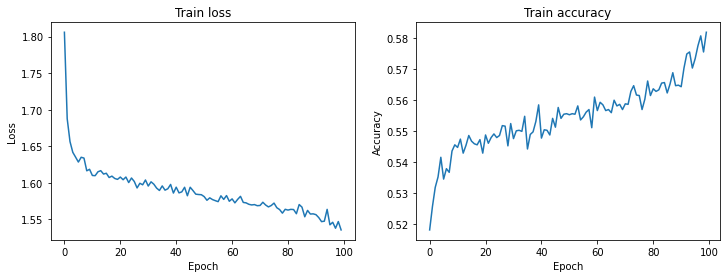

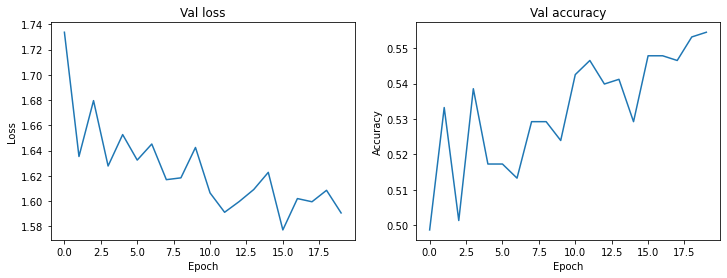

In [8]:
# Run info:
model_name = 'EmotionLSTMTransformer'
print(f'Model: {model_name}')
print(f'Epochs: ', epochs)
print(f'Learning rate: ', lr)
print(f'Weight decay: ', weight_decay)
print(f'Num features: {num_features} ')
print(f'Dropout: {dropout}')
path = f'./Results/{model_name}_{run}'
if not os.path.isdir(path):
    os.mkdir(path)
    
with open(path+'/hyperparameters.txt', 'w') as file:
    file.write(f'Model: {model_name} \n')
    file.write(f'Epochs: {epochs} \n')
    file.write(f'learning rate: {lr} \n')
    file.write(f'weight decay: {weight_decay} \n')
    file.write(f'Num features: {num_features} \n ')
    file.write(f'num layers: {num_layers} \n')
    file.write(f'dropout: {dropout} \n')

# Train plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(losses)
ax2.plot(accuracies)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.set_title('Train loss')
ax2.set_title('Train accuracy')
plt.savefig(path+'/train_plots.png')
plt.show()

# Val plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(val_loss)
ax2.plot(val_accuracy)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.set_title('Val loss')
ax2.set_title('Val accuracy')
plt.savefig(path+'/val_plots.png')
plt.show()

# Save the trained model
torch.save(model.state_dict(), path+'/'+model_name+'_state_dict.pt')

In [9]:
# Run testing on the results
model.eval()
correct_test = 0
test_loss = 0
total_macro = 0
total_micro = 0
for x,y in test_loader:
    x_cuda = x.cuda()
    y_cuda = torch.squeeze(y).cuda()

    # Output from mode
    output = model(x_cuda)
    output = output.cuda()
    
    # Loss
    loss = criterion(output, y_cuda)

    # Need to take max over the log probs (batch_size, num_classes)
    _, pred = torch.max(output, 1)
    pred = pred.type(torch.FloatTensor).cuda()

    num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
    
    f1 = f1_score(y_cuda.cpu().detach().numpy(), pred.cpu().detach().numpy(), average='macro')
    total_macro += f1
    f1 = f1_score(y_cuda.cpu().detach().numpy(), pred.cpu().detach().numpy(), average='micro')
    total_micro += f1
    
    correct_test += num_correct
    test_loss += loss
# Calculate average loss
epoch_loss = test_loss / len(test_loader)

# Accuracy
accuracy = correct_test / (len(test_loader) * batch_size)
avg_macro = total_macro / len(test_loader)
avg_micro = total_micro / len(test_loader)
print("Test loss: %.3f , Test Accuracy: %.3f, Avg F1 macro: %.4f, Avg F1 micro: %.3f" % 
      (epoch_loss, accuracy, avg_macro, avg_micro))

Test loss: 1.521 , Test Accuracy: 0.612, Avg F1 macro: 0.2649, Avg F1 micro: 0.617


In [10]:
# Save test result
with open(path+'/test_results.txt', 'w') as f:
    f.write("Test loss: %.3f , Test Accuracy: %.3f, Avg F1 macro: %.4f, Avg F1 micro: %.3f" % 
      (epoch_loss, accuracy, avg_macro, avg_micro))

In [11]:
# Create dataset from the data
class CREMADataset(Dataset):
    """
    CREMA-D dataset to load and use
    """
    def __init__(self, X, Y, num_examples, split='train', train_ratio = 0.8, val_ratio = 0.1):
        super().__init__()
        # X are the features, Y are the labels
        self.Y = Y  
        self.X = X
        self.num_examples = num_examples
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio

        # Decides which indices belong to which split.
        train_indices, val_indices, test_indices = self.split_data(num_examples, train_ratio=train_ratio, val_ratio=val_ratio)

        if split == 'train':
            indices = train_indices
        elif split == 'val':
            indices = val_indices
        elif split == 'test':
            indices = test_indices
        else:
            raise Exception(f'Split {split} not supported.')
            
        self.indices = indices

    def split_data(self, num_examples, train_ratio = 0.8, val_ratio = 0.1):
        """Splits data into train, val, and test sets based on speaker. When 
        evaluating methods on the test split, we measure how well they generalize
        to new (unseen) speakers.

        Concretely, this stores and returns indices belonging to each split.
        """
        # Fix seed so everyone reproduces the same splits.
        rs = np.random.RandomState(42)

        indices = np.arange(0, num_examples)
        train_idx = int(num_examples * train_ratio)
        num_remaining = num_examples - train_idx
        val_idx = train_idx + int(num_remaining/2)
        
        print(f'train idx: {train_idx}')
        print(f'val idx: {val_idx}')
        
        train_indices = indices[:train_idx]
        val_indices = indices[train_idx:val_idx]
        test_indices = indices[val_idx:]
        return train_indices, val_indices, test_indices

    def __getitem__(self, index):
        index = self.indices[index]
        return torch.FloatTensor(self.X[index,:]), torch.LongTensor([self.Y[index]])

    def __len__(self):
        """Returns total number of utterances in the dataset."""
        return len(self.indices)


In [12]:
# Define the transformer
class MLP(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        # Initialize layers
        self.linear = nn.Linear(input_dim, n_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        output = self.linear(x)
        result = self.relu(output)
        return result
    
class EmotionTransformerPrototype(nn.Module):
    def __init__(self, input_dim, num_class, num_layers=2, hidden_dim=128):
        super().__init__()
        # Note: `batch_first=True` argument implies the inputs to the LSTM should
        # be of shape (batch_size x T x D) instead of (T x batch_size x D).
        self.encoder = MLP(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, num_class)
        self.input_dim = input_dim
        self.num_class = num_class
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
    def forward(self, inputs):
        log_probs = None
        # Hint: This is an N-way classification problem.
        embed = self.encoder(inputs)
        output = self.decoder(embed)
        # Softmax for N-way classification, followed by log to make them log_probs
        # log_probs = F.log_softmax(output, dim=2)
        log_probs = F.log_softmax(output, dim=-1)
        # If log softmax --> use negative log likelihood loss
        # If normal probabilities --> use normal cross entropy (equivalent methods!)
        return log_probs
  
    def get_loss(self, probs, targets):
        loss = None
        # Cross entropy loss if probs is normal probabilities
        # Negative log likelihood if probs is log probs
        # probs = probs.view(-1)
        # targets = targets.view(-1).type(dtype=torch.float) # --> float()
        # loss = F.cross_entropy(probs, targets)
        loss = F.nll_loss(probs, targets)
        return loss

class EmotionCNNTransformer(nn.Module):
    def __init__(
          self, input_dim, num_class, kernel_size, num_layers=2, hidden_dim=128, stride=1, padding=0):
        super().__init__()
        # Note: `batch_first=True` argument implies the inputs to the LSTM should
        # be of shape (batch_size x T x D) instead of (T x batch_size x D).
        self.encoder = nn.Conv1d(input_dim, hidden_dim, kernel_size, stride=stride, padding=padding)
        self.decoder = nn.Linear(hidden_dim, num_class)
        self.input_dim = input_dim
        self.num_class = num_class
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

    
class EmotionRNNTransformer(nn.Module):
    """
  Encoder-Decoder model to classify emotions for utterances.

  Args:
    input_dim: integer
                number of input features
    num_class: integer
                number of class labels
    num_layers: integer (default: 2)
                number of layers in encoder LSTM
    hidden_dim: integer (default: 128)
                number of hidden dimensions for encoder LSTM
    bidirectional: boolean (default: True)
                    is the encoder LSTM bidirectional?
  """
    def __init__(
          self, input_dim, num_class, num_layers=2, hidden_dim=128,
          bidirectional=True):
        super().__init__()
        # Note: `batch_first=True` argument implies the inputs to the LSTM should
        # be of shape (batch_size x T x D) instead of (T x batch_size x D).
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                                bidirectional=bidirectional, batch_first=True)
        self.decoder = nn.Linear(hidden_dim * 2, num_class)
        self.input_dim = input_dim
        self.num_class = num_class
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = hidden_dim * num_layers * 2 * \
                              (2 if bidirectional else 1)

    def combine_h_and_c(self, h, c):
        """Combine the signals from RNN hidden and cell states."""
        batch_size = h.size(1)
        h = h.permute(1, 0, 2).contiguous()
        c = c.permute(1, 0, 2).contiguous()
        h = h.view(batch_size, -1)
        c = c.view(batch_size, -1)
        return torch.cat([h, c], dim=1)  # just concatenate

    def forward(self, inputs, input_lengths):
        batch_size, max_length, _ = inputs.size()
        # `torch.nn.utils.rnn.pack_padded_sequence` collapses padded sequences
        # to a contiguous chunk
        inputs = torch.nn.utils.rnn.pack_padded_sequence(
            inputs, input_lengths.cpu(), batch_first=True, enforce_sorted=False)
        log_probs = None
        h, c = None, None
        ############################ START OF YOUR CODE ############################
        # TODO(2.1)
        # Hint:
        # - Refer to https://pytorch.org/docs/stable/nn.html
        # - Use `self.encoder` to get the encodings output which is of shape
        #   (batch_size, max_length, num_directions*hidden_dim) and the
        #   hidden states and cell states which are both of shape
        #   (batch_size, num_layers*num_directions, hidden_dim)
        # - Pad outputs with `0.` using `torch.nn.utils.rnn.pad_packed_sequence`
        #   (turn on batch_first and set total_length as max_length).
        # - Apply 50% dropout.
        # - Use `self.decoder` to take the embeddings sequence and return
        #   probabilities for each character.
        # - Make sure to then convert to log probabilities.

        # Get encodings
        encodings, (h, c) = self.encoder(inputs)

        # Pad outputs with '0'
        padded, lengths = torch.nn.utils.rnn.pad_packed_sequence(encodings, batch_first=True, total_length=max_length)

        # Apply dropout
        dropout = nn.Dropout(p=0.5)
        dropped_padded = dropout(padded)

        # Decode to get probabilies dimensions (batch_size, time steps, num chars <vocab>)
        probabilities = self.decoder(dropped_padded)

        # Log probabilities
        # dim=2 because softmax over the vocabulary dimension. dim=1 is over time steps
        log_probs = F.log_softmax(probabilities, dim=2)

        ############################# END OF YOUR CODE #############################

        # The extracted embedding is not used for the ASR task but will be
        # needed for other auxiliary tasks.
        embedding = self.combine_h_and_c(h, c)
        return log_probs, embedding

    def get_loss(self, log_probs, targets):
            # cross-entropy for softmax/negative log likelihood loss for log softmax
        return F.nll_loss(probs, targets)

    def decode(self, log_probs, input_lengths, labels, label_lengths):
        # Use greedy decoding.
        decoded = torch.argmax(log_probs, dim=2)
        batch_size = decoded.size(0)

        hypothesis_lengths = input_lengths.cpu().numpy().tolist()
        if labels is None: # Run at inference time.
          references, reference_lengths = None, None
        else:
          references = labels.cpu().numpy().tolist()
          reference_lengths = label_lengths.cpu().numpy().tolist()

        return hypotheses, hypothesis_lengths, references, reference_lengths

In [13]:
# Get data and labels for training
# train_split = int(0.8 * num_files)
# print('train_split: ', train_split)
# print(f'train size: {X[:train_split].shape}, val size: {X[train_split:].shape}')

# model = LogisticRegression().fit(X[:train_split], Y[:train_split])

# # Predict on validation/test (80-20 split)
# predictions = model.predict(X[train_split:])

# # Output score (mean accuracy)
# score = model.score(X[train_split:],Y[train_split:])
# print(f'Test accuracy score: {score}')

# f1 = f1_score(Y[train_split:], predictions, average='macro')
# print(f'macro f1 score: {f1}')
# f1 = f1_score(Y[train_split:], predictions, average='micro')
# print(f'micro f1 score: {f1}')

In [14]:
# Some basic stats for the dataset
# avg = np.mean(X, axis=0)
# print(f'avg shape: {avg.shape}')
# stats = ['f0_min', 'f0_max', 'f0_mean', 'f0_range', 'duration', 'rms_min', 'rms_max', 'rms_mean', 'pitch_max', 'pitch_min', 
#                   'pitch_range', 'pitch_mean']
# stats = ['f0_min', 'f0_max', 'f0_mean', 'f0_range', 'duration', 'rms_min', 'rms_max', 'rms_mean']
# for j,stat in enumerate(stats):
#     print(f'{stat} average: {avg[j]}')